In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../scripts")

from statfenics.utils import build_observation_operator
from swe import ShallowOne
from swe_filter import ShallowOneEx

In [2]:
NX = 400
DT = 2.5

# set the observation system
NT_WARMUP = 400
NT = 1001
NT_PRED = 100
SIGMA_Y = 5e-3

In [3]:
def extract_components(swe):
    u_out = swe.du.compute_vertex_values()[:(NX + 1)]
    h_out = swe.du.compute_vertex_values()[(NX + 1):]
    return u_out, h_out

In [4]:
def compute_base_dataset(nu):
    control = {"nx": NX, "dt": DT, "theta": 1.0, "simulation": "tidal_flow"}
    params = {"nu": nu}
    swe_dgp = ShallowOne(control, params)
    
    t = 0.
    for i in range(NT_WARMUP):
        t += swe_dgp.dt
        swe_dgp.solve(t)
    
    du_init = swe_dgp.du.vector().get_local().copy()
    nx_save = swe_dgp.du.compute_vertex_values()[(NX + 1):].shape[0]
    h_obs = np.zeros((NT, nx_save))
    
    for i in range(NT):
        t += swe_dgp.dt
        swe_dgp.solve(t)
        h_obs[i, :] = swe_dgp.du.compute_vertex_values()[(NX + 1):]
        
    return h_obs, du_init
        
h_obs, du_init = compute_base_dataset(1e-1)

In [5]:
def compute_errors(h_obs, du_init, nt_skip, nx_skip, final=False):
    # setup dynamical systems
    norm = np.linalg.norm
    control = {"nx": NX, "dt": DT, "theta": 1.0, "simulation": "tidal_flow"}
    params = {"nu": 1.}
    swe_post = ShallowOneEx(control, params, {"rho": 1e-2, "ell": 1}, lr=False)

    # build obs. operator
    x_obs = swe_post.x_coords[::nx_skip]  # every 5th location
    n_obs = len(x_obs)
    y_obs = np.zeros((n_obs, ))
    H_obs = build_observation_operator(x_obs, swe_post.W, sub=1, out="scipy")

    print(f"Warming up for {NT_WARMUP} iterations")
    print(f"Assimilating every {nt_skip} timesteps ({nt_skip * swe_post.dt:.3f} s)")
    print(f"Observational noise has std. dev. {SIGMA_Y:.4e}")
    print(f"Assimilating {H_obs.shape[0]} data points per time")

    # initialize from warmed-up iterations
    t = NT_WARMUP * swe_post.dt
    swe_post.du.vector().set_local(du_init)
    swe_post.du_prev.vector().set_local(du_init)

    if not final:
        error_h = np.zeros((NT, ))

    for i in range(NT):
        t += swe_post.dt

        swe_post.prediction_step(t)
        if i % nt_skip == 0:
            y_obs[:] = h_obs[i, ::nx_skip]
            y_obs += SIGMA_Y * np.random.normal(size=(n_obs, ))
            swe_post.update_step(y_obs, H_obs, SIGMA_Y)

        swe_post.set_prev()
        
        if not final:
            h_true = h_obs[i, :]
            _, h_mean = extract_components(swe_post)
            error_h[i] = norm(h_true - h_mean) / norm(h_true)
            
    if final:
        h_true = h_obs[i, :]
        _, h_mean = extract_components(swe_post)
        error_h = norm(h_true - h_mean) / norm(h_true)
        
    return error_h

In [6]:
from multiprocessing import Pool

nt_skip = [1, 4, 10, 20, 40, 100]
nx_skip = [4, 8, 16, 24, 40]

args = []
for nt in nt_skip:
    for nx in nx_skip:
        args.append([h_obs, du_init, nt, nx, True])


p = Pool(6)
errors = p.starmap(compute_errors, args)

Warming up for 400 iterations
Assimilating every 1 timesteps (2.500 s)
Observational noise has std. dev. 5.0000e-03
Assimilating 101 data points per time
Warming up for 400 iterations
Assimilating every 1 timesteps (2.500 s)
Observational noise has std. dev. 5.0000e-03
Assimilating 26 data points per time
Warming up for 400 iterations
Assimilating every 1 timesteps (2.500 s)
Observational noise has std. dev. 5.0000e-03
Assimilating 11 data points per time
Warming up for 400 iterations
Assimilating every 4 timesteps (10.000 s)
Observational noise has std. dev. 5.0000e-03
Assimilating 51 data points per time
Warming up for 400 iterations
Assimilating every 4 timesteps (10.000 s)
Observational noise has std. dev. 5.0000e-03
Assimilating 17 data points per time
Warming up for 400 iterations
Assimilating every 10 timesteps (25.000 s)
Observational noise has std. dev. 5.0000e-03
Assimilating 101 data points per time
Warming up for 400 iterations
Assimilating every 1 timesteps (2.500 s)
Obser

In [7]:
errors[0]

0.0014585539550466028

In [8]:
error_matrix = [[] for i in range(len(nt_skip))]

idx = 0
for i in range(len(nt_skip)):
    for j in range(len(nx_skip)):
        error_matrix[i].append(errors[idx])
        idx += 1
        
print(error_matrix)

[[0.0014585539550466028, 0.004019458587631358, 0.003780990043420586, 0.007152996278251338, 0.004765536638283807], [0.0022560448947787255, 0.00274227094767456, 0.0028646578135126106, 0.005563864249692534, 0.006282492971753928], [0.0013892726557425208, 0.0037345639142087094, 0.003148683241660152, 0.0059434183977239066, 0.010189261380843528], [0.002346757150972655, 0.004357275026945274, 0.00439896662517396, 0.0040862415467443, 0.006623786043725754], [0.002106463117277141, 0.0036107967634522765, 0.006480561071447327, 0.0077495956072904885, 0.007213932865785069], [0.001520230891535534, 0.0032712581759071105, 0.008300673178129823, 0.007861373384760926, 0.004280923661954858]]


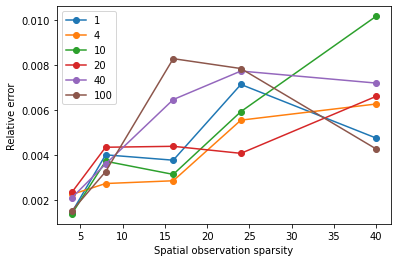

In [9]:
for i in range(len(nt_skip)):
    plt.plot(nx_skip, error_matrix[i], "o-", label=nt_skip[i])
    
plt.legend()
plt.xlabel("Spatial observation sparsity")
plt.ylabel("Relative error")
plt.show()

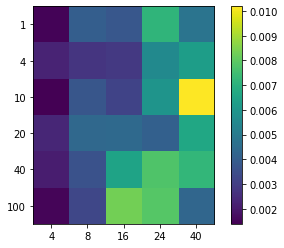

In [10]:
fig, ax = plt.subplots()
im = ax.imshow(error_matrix)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(nx_skip)), labels=nx_skip)
ax.set_yticks(np.arange(len(nt_skip)), labels=nt_skip)

plt.colorbar(im, ax=ax)
plt.show()